<a href="https://colab.research.google.com/github/HasiniSandunika/DM-Project/blob/main/DM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from keras.models import load_model
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
look_back=1

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
def read_data(path):
  data = pd.read_csv(path)
  print(data.head())
  print('\nData Types:')
  print(data.dtypes)
  data.set_index('index', inplace=True)
  print('\nTime series of reporting daily cases')
  ts = data['cases']
  plt.plot(ts)
  plt.show()

In [3]:
def create_dataset(dataset, look_back=1):
	x, y = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		x.append(a)
		y.append(dataset[i + look_back, 0])
	return numpy.array(x), numpy.array(y)

In [4]:
def data_preprocessing(read_path):
  numpy.random.seed(7)
  dataframe = read_csv(read_path, usecols=[1], engine='python')
  dataset = dataframe.values
  dataset = dataset.astype('float32')
  scaler = MinMaxScaler(feature_range=(0, 1))
  dataset = scaler.fit_transform(dataset)
  train_size = int(len(dataset) * 0.67)
  test_size = len(dataset) - train_size
  train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
  look_back = 1
  trainX, trainY = create_dataset(train, look_back)
  testX, testY = create_dataset(test, look_back)
  trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
  testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
  return trainX, trainY, testX, testY

In [5]:
def create_model_all(train_x, train_y):
  model = Sequential()
  model.add(LSTM(4, input_shape=(1, look_back)))
  model.add(Dense(1))
  model.compile(loss='mean_squared_error', optimizer='adam')
  model.summary()
  return model

In [6]:
def create_model_1(train_x, train_y):
  model = Sequential()
  model.add(LSTM(8, input_shape=(1, look_back)))
  model.add(Dense(1))
  model.compile(loss='mean_squared_error', optimizer='adam')
  model.summary()
  return model

In [7]:
def create_model_2(train_x, train_y):
  model = Sequential()
  model.add(LSTM(4, input_shape=(1, look_back)))
  model.add(Dense(1))
  model.compile(loss='mean_squared_error', optimizer='adam')
  model.summary()
  return model

In [8]:
def train_model(read_path, save_path, status):
  train_x, train_y, test_x, test_y = data_preprocessing(read_path)
  print('\nLSTM model')
  if status==0:
    model=create_model_all(train_x, train_y)
    model_fit = model.fit(train_x, train_y, epochs=500, batch_size=16, verbose=1)                         
    print('Graph of epochs vs loss')
    %matplotlib inline 
    plt.figure() 
    plt.xlabel('Epochs') 
    plt.ylabel('Loss') 
    plt.plot(model_fit.history['loss']) 
    plt.legend(['Training'])
    plt.figure() 
    plt.show()
    model.save(save_path)
  elif status==1:
    model=create_model_1(train_x, train_y)
    model_fit = model.fit(train_x, train_y, epochs=200, batch_size=32, verbose=1)
    print('Graph of epochs vs loss')
    %matplotlib inline 
    plt.figure() 
    plt.xlabel('Epochs') 
    plt.ylabel('Loss') 
    plt.plot(model_fit.history['loss']) 
    plt.legend(['Training'])
    plt.figure() 
    plt.show()
    model.save(save_path)
  elif status==2:
    model=create_model_2(train_x, train_y)
    model_fit = model.fit(train_x, train_y, epochs=200, batch_size=16, verbose=1) 
    print('Graph of epochs vs loss')
    %matplotlib inline 
    plt.figure() 
    plt.xlabel('Epochs') 
    plt.ylabel('Loss') 
    plt.plot(model_fit.history['loss']) 
    plt.legend(['Training'])
    plt.figure() 
    plt.show()
    model.save(save_path)

In [9]:
def test_model(read_path, save_path):
  train_x, train_y, test_x, test_y = data_preprocessing(read_path)
  model = load_model(save_path)
  print('\nLSTM model')
  model.summary()
  trainPredict = model.predict(train_x)
  testPredict = model.predict(test_x)
  dataframe = read_csv(read_path, usecols=[1], engine='python')
  dataset = dataframe.values
  dataset = dataset.astype('float32')
  scaler = MinMaxScaler(feature_range=(0, 1))
  dataset = scaler.fit_transform(dataset)
  trainPredict = scaler.inverse_transform(trainPredict)
  train_y = scaler.inverse_transform([train_y])
  testPredict = scaler.inverse_transform(testPredict)
  test_y = scaler.inverse_transform([test_y])
  trainScoreRMSE = mean_squared_error(train_y[0], trainPredict[:,0])
  trainScore = r2_score(train_y[0], trainPredict[:,0])
  print('\n')
  print('Train Score: %.2f R2' % (trainScore))
  print('Train Score: %.2f MSE' % (trainScoreRMSE))
  testScoreRMSE = mean_squared_error(test_y[0], testPredict[:,0])
  testScore = r2_score(test_y[0], testPredict[:,0])
  print('Test Score: %.2f R2' % (testScore))
  print('Test Score: %.2f MSE' % (testScoreRMSE))
  print('\n')
  trainPredictPlot = numpy.empty_like(dataset)
  trainPredictPlot[:, :] = numpy.nan
  trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
  testPredictPlot = numpy.empty_like(dataset)
  testPredictPlot[:, :] = numpy.nan
  testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
  plt.plot(scaler.inverse_transform(dataset)) # min max scaled, inverse transformed original dataset-blue
  plt.plot(trainPredictPlot)# first half train-orange  
  plt.plot(testPredictPlot) # second half test-green 
  plt.show()

In [10]:
def fit_stat_regression_model(file_path):
  dataframe = read_csv(file_path, usecols=[1], engine='python')
  dataset = dataframe.values
  dataset = dataset.astype('float32')
  look_back = 1
  trainX, trainY = create_dataset(dataset, look_back)
  X = sm.add_constant(trainX)
  model = sm.OLS(trainY, X)
  results = model.fit()
  print(results.summary())
  print('\n')
  print('coefficient of determination (R2):', results.rsquared)
  print('adjusted coefficient of determination (adj-R2):', results.rsquared_adj)
  print('regression coefficients:', results.params)
  print('\n')
  y=results.params[0]+ results.params[1]*trainX
  plt.scatter(trainX, trainY, marker='o',color='red')
  plt.plot(trainX, y, '-')
  plt.xlabel('dataset')
  plt.ylabel('prediction') 
  plt.title('prediction vs dataset')
  plt.show() 

In [11]:
def train_regression_model(file_path):
  dataframe = read_csv(file_path, usecols=[1], engine='python')
  dataset = dataframe.values
  dataset = dataset.astype('float32')
  look_back = 1
  trainX, trainY = create_dataset(dataset, look_back)
  model = LinearRegression().fit(trainX, trainY)
  print('coefficient of determination (R2):', model.score(trainX, trainY))
  print('intercept:', model.intercept_)
  print('slope:', model.coef_)
  y=model.intercept_+ model.coef_*trainX
  plt.scatter(trainX, trainY, marker='o',color='red')
  plt.plot(trainX, y, '-')
  plt.xlabel('train dataset')
  plt.ylabel('prediction') 
  plt.title('prediction vs train dataset')
  plt.show() 

   index  cases
0      1      0
1      2      0
2      3      0
3      4      0
4      5      0

Data Types:
index    int64
cases    int64
dtype: object

Time series of reporting daily cases


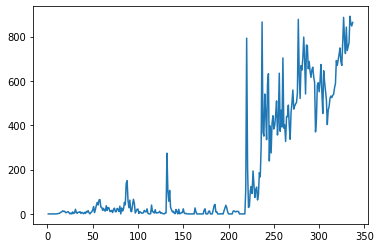


LSTM model
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 4)                 96        
_________________________________________________________________
dense (Dense)                (None, 1)                 5         
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________


Train Score: 0.21 R2
Train Score: 2910.96 MSE
Test Score: -2.62 R2
Test Score: 131666.07 MSE




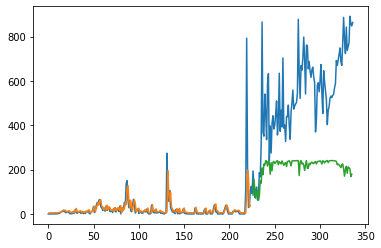


Regression model
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.879
Model:                            OLS   Adj. R-squared:                  0.879
Method:                 Least Squares   F-statistic:                     2418.
Date:                Thu, 25 Feb 2021   Prob (F-statistic):          9.46e-155
Time:                        03:22:03   Log-Likelihood:                -1994.8
No. Observations:                 335   AIC:                             3994.
Df Residuals:                     333   BIC:                             4001.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.6784      6.238  

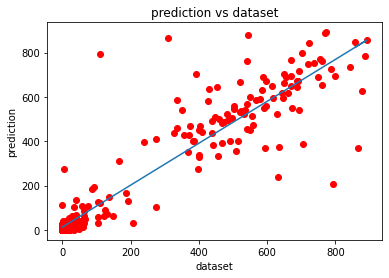

coefficient of determination (R2): 0.8789597921219128
intercept: 12.678452
slope: [0.9454439]


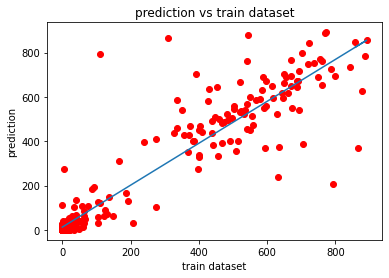

In [12]:
def main(): 
  model_all_save="/content/drive/MyDrive/DM_Assignment/DM_model_case_all.h5"
  model_1_save="/content/drive/MyDrive/DM_Assignment/DM_model_case_1.h5"
  model_2_save="/content/drive/MyDrive/DM_Assignment/DM_model_case_2.h5"
  case_all_csv='/content/drive/MyDrive/DM_Assignment/cases_all.csv'
  case_1_csv='/content/drive/MyDrive/DM_Assignment/cases_1.csv'
  case_2_csv='/content/drive/MyDrive/DM_Assignment/cases_2.csv'
  #look_back=1
  select_application_type ='test' #@param ["train", "test"]
  dataset_selection ='all' #@param ["all", "case_1", "case_2"]
  if select_application_type=='train' and dataset_selection =='all':
    read_data(case_all_csv)
    train_model(case_all_csv, model_all_save, 0)
  elif select_application_type=='train' and dataset_selection =='case_1':
    read_data(case_1_csv)
    train_model(case_1_csv, model_1_save, 1)
  elif select_application_type=='train' and dataset_selection =='case_2':
    read_data(case_2_csv)
    train_model(case_2_csv, model_2_save, 2)
  elif select_application_type=='test' and dataset_selection =='all':
    read_data(case_all_csv)    
    test_model(case_all_csv, model_all_save)
    print("\nRegression model")
    fit_stat_regression_model(case_all_csv)
    train_regression_model(case_all_csv)
  elif select_application_type=='test' and dataset_selection =='case_1':
    read_data(case_1_csv)
    test_model(case_1_csv, model_1_save)
    print("\nRegression model")
    fit_stat_regression_model(case_1_csv)
    train_regression_model(case_1_csv)
  elif select_application_type=='test' and dataset_selection =='case_2':
    read_data(case_2_csv)
    test_model(case_2_csv, model_2_save)
    print("\nRegression model")
    fit_stat_regression_model(case_2_csv)
    train_regression_model(case_2_csv)

if __name__ == "__main__":
        main()